In [8]:
# Importing modules
import pandas as pd
import os

In [9]:
def load_outlet_reviews(outlet_name, base_path='../Reviews/All/'):
    """
    Load reviews for a specific Anytime Fitness outlet
    
    Parameters:
    outlet_name (str): Name of the outlet (e.g., 'Anytime Fitness Buona Vista')
    base_path (str): Base directory path where review CSV files are stored
    
    Returns:
    pandas.DataFrame: DataFrame containing the outlet's reviews
    """
    # Construct the filename
    filename = f"{outlet_name}_reviews.csv"
    filepath = os.path.join(base_path, filename)
    
    try:
        # Read the CSV file
        outlet_reviews = pd.read_csv(filepath, encoding='utf-8')
        
        return outlet_reviews
        
    except FileNotFoundError:
        if os.path.exists(base_path):
            csv_files = [f for f in os.listdir(base_path) if f.endswith('_reviews.csv')]
            for file in csv_files[:10]:  # Show first 10 files
                print(f"   - {file}")
            if len(csv_files) > 10:
                print(f"   ... and {len(csv_files) - 10} more files")
        return pd.DataFrame()
    
    except Exception as e:
        return pd.DataFrame()

In [10]:
# Initialize dictionary to store DataFrames for each outlet
outlet_dataframes = {}

# Example usage: Load multiple outlets and store them as separate DataFrames

top_5_outlets = [
    'Anytime Fitness MacPherson Mall', 
    'Anytime Fitness Bedok 85', 
    'Anytime Fitness Bukit Timah Central', 
    'Anytime Fitness Buona Vista',
    'Anytime Fitness Havelock Outram'
]

bottom_5_outlets = [ 
    'Anytime Fitness Northpoint City', 
    'Anytime Fitness NEX', 
    'Anytime Fitness hillV2', 
    'Anytime Fitness Upper Cross Street', 
    'Anytime Fitness Kovan'
]

for top_outlet in top_5_outlets:
    top5 = load_outlet_reviews(top_outlet)
    if not top5.empty:
        outlet_dataframes[top_outlet] = top5

for bottom_outlet in bottom_5_outlets:
    bot5 = load_outlet_reviews(bottom_outlet)
    if not bot5.empty:
        outlet_dataframes[bottom_outlet] = bot5


# Display summary of all outlet DataFrames
print("\n" + "=" * 60)
print("📊 OUTLET DATAFRAMES SUMMARY")
print("=" * 60)

if outlet_dataframes:
    print(f"Total outlets loaded: {len(outlet_dataframes)}")
    total_reviews = sum(len(df) for df in outlet_dataframes.values())
    print(f"Total reviews across all outlets: {total_reviews}")
    
    print(f"\n🏢 Reviews per outlet DataFrame:")
    for outlet_name, df in outlet_dataframes.items():
        print(f"   {outlet_name}: {len(df)} reviews")
        
        if 'rating' in df.columns:
            avg_rating = df['rating'].mean()

    


📊 OUTLET DATAFRAMES SUMMARY
Total outlets loaded: 10
Total reviews across all outlets: 4290

🏢 Reviews per outlet DataFrame:
   Anytime Fitness MacPherson Mall: 126 reviews
   Anytime Fitness Bedok 85: 1003 reviews
   Anytime Fitness Bukit Timah Central: 882 reviews
   Anytime Fitness Buona Vista: 773 reviews
   Anytime Fitness Havelock Outram: 606 reviews
   Anytime Fitness Northpoint City: 244 reviews
   Anytime Fitness NEX: 295 reviews
   Anytime Fitness hillV2: 112 reviews
   Anytime Fitness Upper Cross Street: 142 reviews
   Anytime Fitness Kovan: 107 reviews


In [11]:
# Function to switch between outlets for analysis
def select_outlet_for_analysis(outlet_name):
    """
    Select an outlet for detailed analysis
    
    Parameters:
    outlet_name (str): Name of the outlet to analyze
    
    Returns:
    pandas.DataFrame: Processed DataFrame ready for analysis
    """
    if outlet_name in outlet_dataframes:
        selected_reviews = outlet_dataframes[outlet_name].copy()
        
        # Remove unnecessary columns if they exist
        columns_to_remove = ['author', 'date_posted']
        existing_columns = [col for col in columns_to_remove if col in selected_reviews.columns]
        if existing_columns:
            selected_reviews = selected_reviews.drop(columns=existing_columns)
        
        return selected_reviews
    else:
        print(f"❌ Outlet '{outlet_name}' not found")
        return pd.DataFrame()

In [12]:
def analyze_outlet_topics(outlet_name, num_topics=5):
    """
    Perform topic modeling analysis on a specific outlet
    
    Parameters:
    outlet_name (str): Name of the outlet to analyze
    num_topics (int): Number of topics to extract
    
    Returns:
    tuple: (processed_reviews_df, lda_model, count_vectorizer, count_data)
    """
    print(f"\n🔍 ANALYZING: {outlet_name}")
    print("="*60)
    
    # Select outlet for analysis
    outlet_reviews = select_outlet_for_analysis(outlet_name)
    
    if outlet_reviews.empty:
        return None, None, None, None
    
    # Text preprocessing
    print("🔄 Processing text data...")
    outlet_reviews['text'] = outlet_reviews['text'].fillna('')
    outlet_reviews['review_text_processed'] = outlet_reviews['text'].map(lambda x: re.sub(r'[,.!?;:"()[\]{}]', '', str(x)))
    outlet_reviews['review_text_processed'] = outlet_reviews['review_text_processed'].map(lambda x: x.strip().lower())
    
    # Remove empty reviews
    outlet_reviews = outlet_reviews[outlet_reviews['review_text_processed'] != '']
    print(f"📊 Reviews after preprocessing: {len(outlet_reviews)}")
    
    if len(outlet_reviews) < 5: 
        return outlet_reviews, None, None, None
    
    # Topic modeling setup
    custom_stop_words = [
        'gym', 'fitness', 'anytime', 'af', 'workout', 'exercise',
        'visit', 'go', 'come', 'use', 'work', 'train'
    ]
    
    all_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + custom_stop_words
    
    count_vectorizer = CountVectorizer(
        stop_words=all_stop_words,
        min_df=2,
        max_df=0.8,
        ngram_range=(1, 2)
    )
    
    count_data = count_vectorizer.fit_transform(outlet_reviews['review_text_processed'])
    
    # LDA model
    lda = LDA(n_components=num_topics, random_state=42)
    lda.fit(count_data)
    
    # Print topics
    print(f"\n🎯 Topics found for {outlet_name}:")
    print_topics(lda, count_vectorizer, 8)
    
    return outlet_reviews, lda, count_vectorizer, count_data

# Example usage (uncomment to run):
# outlet_analysis = analyze_outlet_topics("Anytime Fitness Northpoint City", num_topics=5)

In [ ]:
!pip install wordcloud

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

In [15]:
# Function to generate wordclouds for multiple outlets
def generate_outlet_wordclouds(outlet_names, subplot_cols=2, figsize=(15, 10)):
    """
    Generate wordclouds for multiple outlets in a subplot layout
    
    Parameters:
    outlet_names (list): List of outlet names to generate wordclouds for
    subplot_cols (int): Number of columns in subplot layout
    figsize (tuple): Figure size for the overall plot
    """
    import math
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    import re
    
    # Filter outlet names to only include those that exist in our data
    available_outlets = [name for name in outlet_names if name in outlet_dataframes]
    
    if not available_outlets:
        print("❌ None of the specified outlets were found in loaded data")
        print(f"💡 Available outlets: {list(outlet_dataframes.keys())}")
        return
    
    # Calculate subplot layout
    n_outlets = len(available_outlets)
    subplot_rows = math.ceil(n_outlets / subplot_cols)
    
    # Create subplot figure
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=figsize)
    fig.suptitle('WordClouds for Different Anytime Fitness Outlets', fontsize=16, fontweight='bold')
    
    # Handle single subplot case
    if n_outlets == 1:
        axes = [axes]
    elif subplot_rows == 1:
        axes = axes if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()
    
    for i, outlet_name in enumerate(available_outlets):
        # Get outlet data
        outlet_data = outlet_dataframes[outlet_name].copy()
        
        # Process text data
        outlet_data['text'] = outlet_data['text'].fillna('')
        outlet_data['review_text_processed'] = outlet_data['text'].map(
            lambda x: re.sub(r'[,.!?;:"()[\]{}]', '', str(x))
        )
        outlet_data['review_text_processed'] = outlet_data['review_text_processed'].map(
            lambda x: x.strip().lower()
        )
        
        # Remove empty reviews
        outlet_data = outlet_data[outlet_data['review_text_processed'] != '']
        
        if len(outlet_data) == 0:
            print(f"⚠️ No valid text data for {outlet_name}")
            axes[i].text(0.5, 0.5, f'No valid text data\nfor {outlet_name}', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(outlet_name, fontsize=12, fontweight='bold')
            axes[i].axis('off')
            continue
        
        # Join text for wordcloud
        text_for_wordcloud = ' '.join(outlet_data['review_text_processed'].values)
        
        # Create wordcloud
        outlet_wordcloud = WordCloud(
            background_color="white", 
            max_words=100, 
            contour_width=1, 
            contour_color='steelblue',
            width=400, 
            height=300,
            colormap='viridis'
        ).generate(text_for_wordcloud)
        
        # Plot wordcloud
        axes[i].imshow(outlet_wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{outlet_name}\n({len(outlet_data)} reviews)', 
                         fontsize=10, fontweight='bold', pad=10)
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(n_outlets, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage - generate wordclouds for all loaded outlets
print("🏢 Available outlets for wordcloud generation:")
for i, outlet in enumerate(outlet_dataframes.keys(), 1):
    print(f"{i}. {outlet}")

🏢 Available outlets for wordcloud generation:
1. Anytime Fitness MacPherson Mall
2. Anytime Fitness Bedok 85
3. Anytime Fitness Bukit Timah Central
4. Anytime Fitness Buona Vista
5. Anytime Fitness Havelock Outram
6. Anytime Fitness Northpoint City
7. Anytime Fitness NEX
8. Anytime Fitness hillV2
9. Anytime Fitness Upper Cross Street
10. Anytime Fitness Kovan


--------------------Top 5 Outlets--------------------


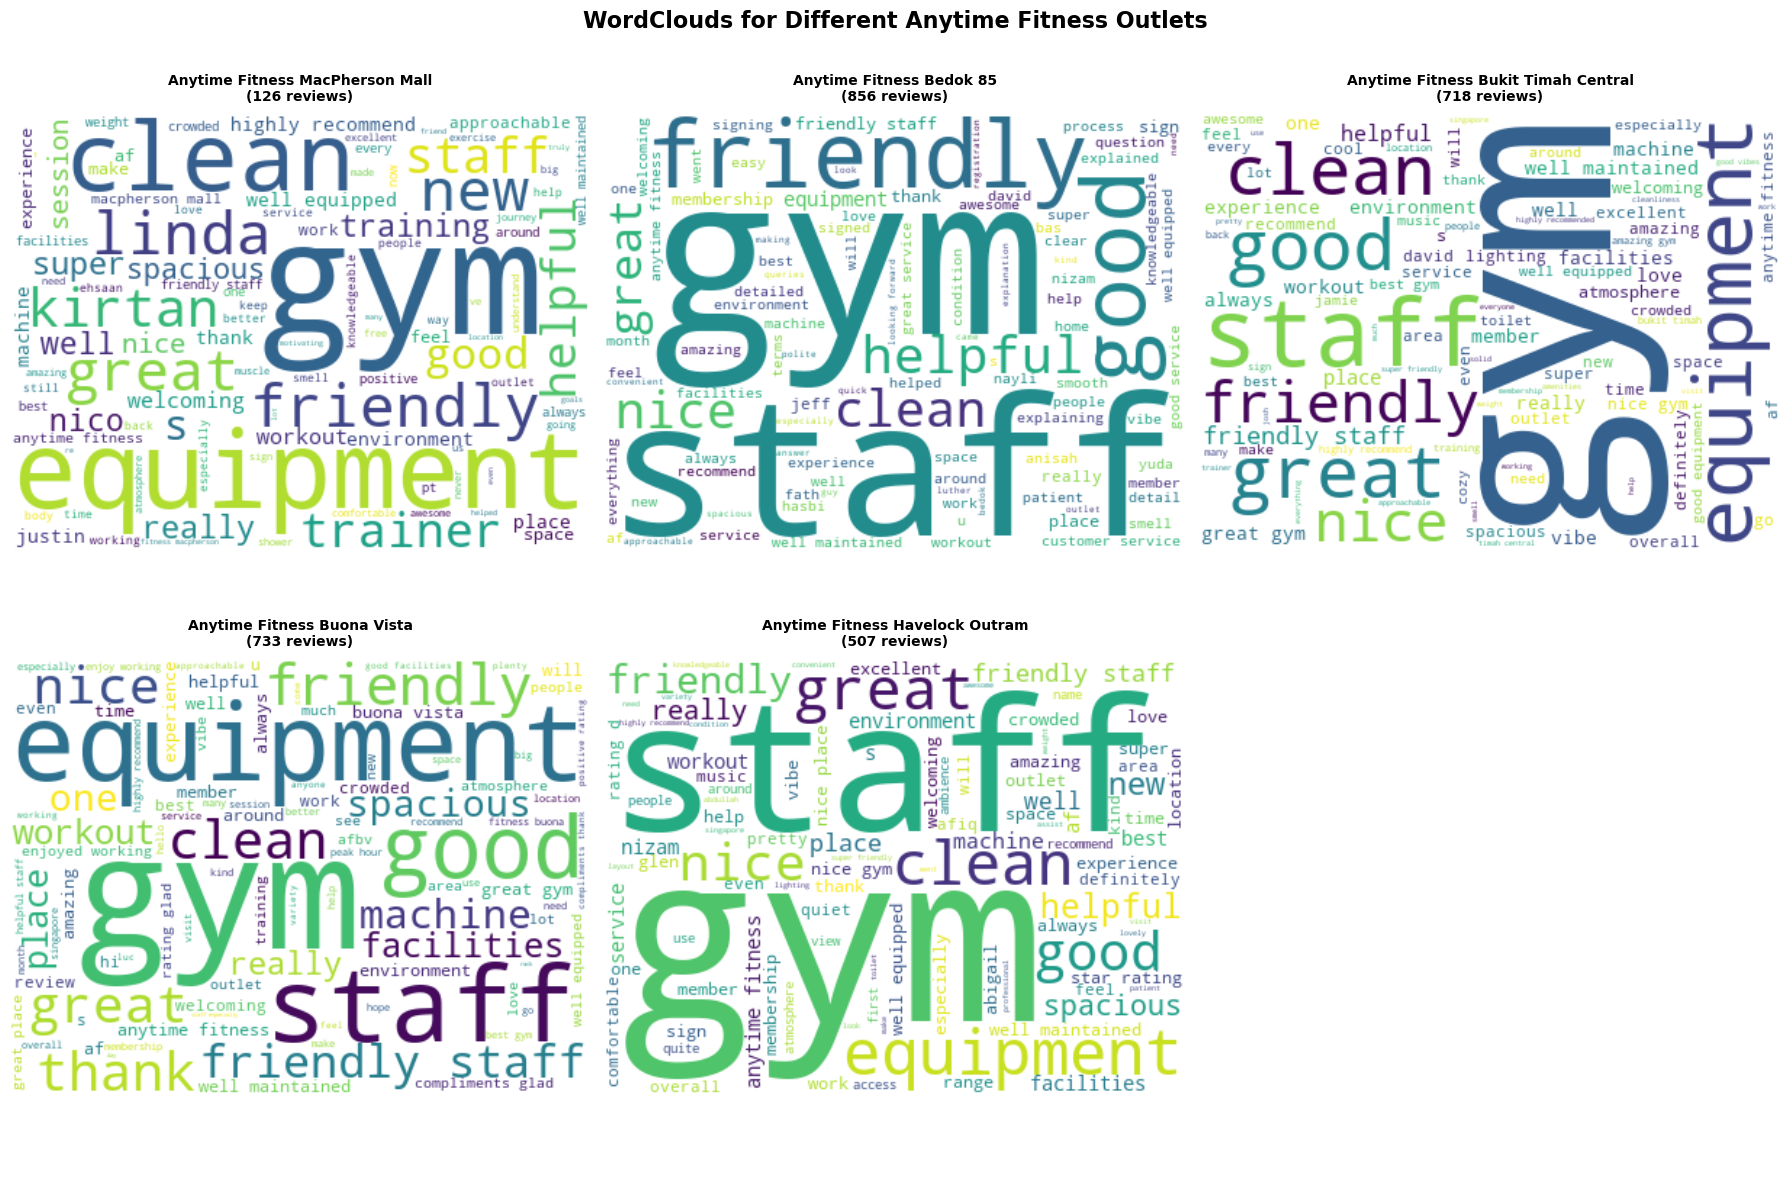

--------------------Bottom 5 Outlets--------------------


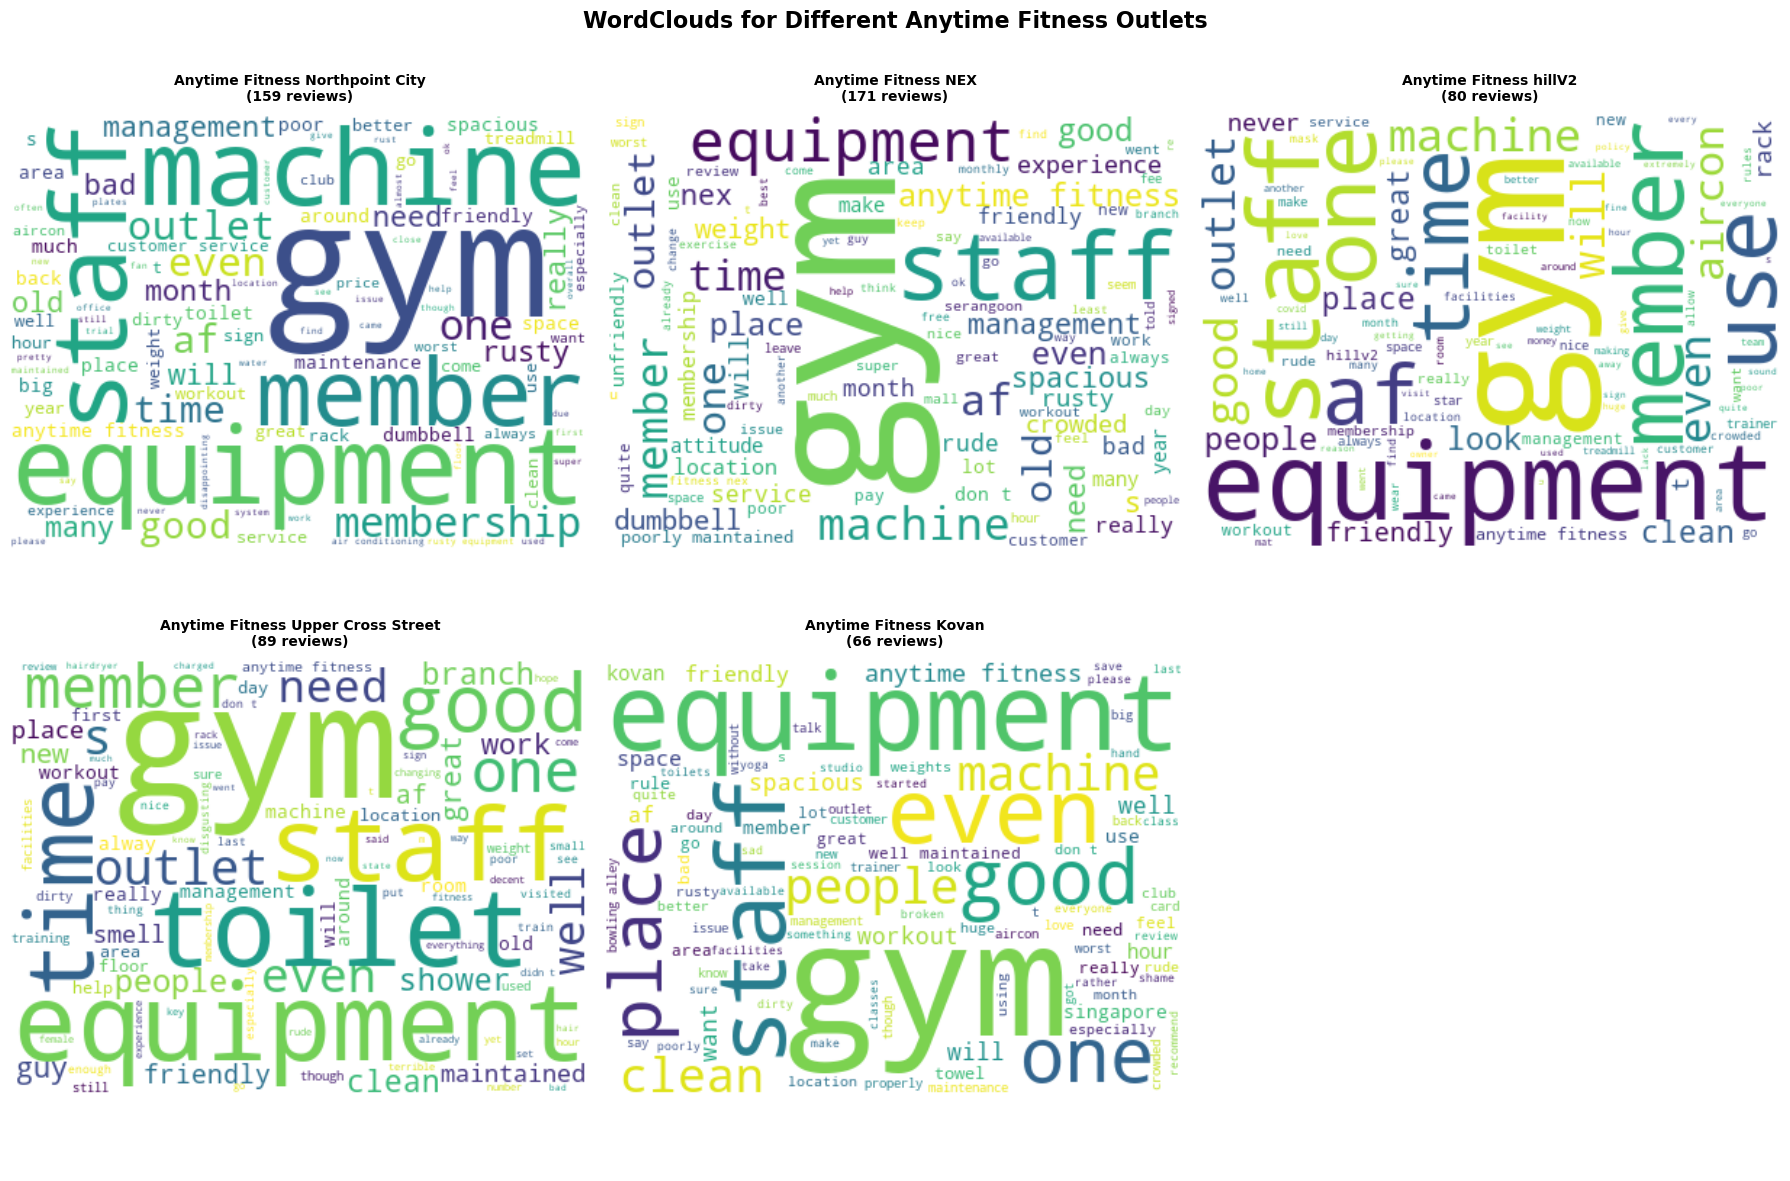


Current outlet DataFrames loaded:
  • Anytime Fitness MacPherson Mall: 126 reviews
  • Anytime Fitness Bedok 85: 1003 reviews
  • Anytime Fitness Bukit Timah Central: 882 reviews
  • Anytime Fitness Buona Vista: 773 reviews
  • Anytime Fitness Havelock Outram: 606 reviews
  • Anytime Fitness Northpoint City: 244 reviews
  • Anytime Fitness NEX: 295 reviews
  • Anytime Fitness hillV2: 112 reviews
  • Anytime Fitness Upper Cross Street: 142 reviews
  • Anytime Fitness Kovan: 107 reviews


In [16]:
# READY-TO-RUN EXAMPLES - Uncomment the line you want to execute

# Example 1: Generate wordclouds for all loaded outlets
# generate_outlet_wordclouds(list(outlet_dataframes.keys()))

# Example 2: Generate wordclouds for specific outlets (customize this list)

top_5_outlets = [
    'Anytime Fitness MacPherson Mall', 
    'Anytime Fitness Bedok 85', 
    'Anytime Fitness Bukit Timah Central', 
    'Anytime Fitness Buona Vista',
    'Anytime Fitness Havelock Outram'
]

bottom_5_outlets = [ 
    'Anytime Fitness Northpoint City', 
    'Anytime Fitness NEX', 
    'Anytime Fitness hillV2', 
    'Anytime Fitness Upper Cross Street', 
    'Anytime Fitness Kovan'
]

print("--------------------Top 5 Outlets--------------------")
generate_outlet_wordclouds(top_5_outlets, subplot_cols=3, figsize=(18, 12))
print("--------------------Bottom 5 Outlets--------------------")
generate_outlet_wordclouds(bottom_5_outlets, subplot_cols=3, figsize=(18, 12))

print()
print("Current outlet DataFrames loaded:")
for outlet_name, df in outlet_dataframes.items():
    print(f"  • {outlet_name}: {len(df)} reviews")

In [ ]:
# Function to analyze top 15 most common words per outlet and plot in one view
def analyze_outlet_word_frequencies(outlet_names, figsize=(20, 15)):
    """
    Analyze top 15 most common words for each outlet and plot them in subplots
    
    Parameters:
    outlet_names (list): List of outlet names to analyze
    figsize (tuple): Figure size for the overall plot
    """
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from sklearn.feature_extraction.text import CountVectorizer
    import re
    
    # Filter outlet names to only include those that exist in our data
    available_outlets = [name for name in outlet_names if name in outlet_dataframes]
    
    if not available_outlets:
        print("❌ None of the specified outlets were found in loaded data")
        print(f"💡 Available outlets: {list(outlet_dataframes.keys())}")
        return
    
    n_outlets = len(available_outlets)
    subplot_cols = 2
    subplot_rows = math.ceil(n_outlets / subplot_cols)
    
    # Create subplot figure
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=figsize)
    fig.suptitle('Top 15 Most Common Words by Outlet (After Filtering)', fontsize=18, fontweight='bold', y=0.98)
    
    # Handle single subplot case
    if n_outlets == 1:
        axes = [axes]
    elif subplot_rows == 1:
        axes = axes if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()
    
    # Define custom stop words (same as before)
    custom_stop_words = [
        'gym', 'fitness', 'anytime', 'af', 'workout', 'exercise',
        'visit', 'go', 'come', 'use', 'work', 'train', 'like'
    ]
    
    # Combine with English stop words
    all_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + custom_stop_words
    
    # Analyze each outlet
    for i, outlet_name in enumerate(available_outlets):
        
        # Get outlet data
        outlet_data = outlet_dataframes[outlet_name].copy()
        
        # Process text data
        outlet_data['text'] = outlet_data['text'].fillna('')
        outlet_data['review_text_processed'] = outlet_data['text'].map(
            lambda x: re.sub(r'[,.!?;:"()[\]{}]', '', str(x))
        )
        outlet_data['review_text_processed'] = outlet_data['review_text_processed'].map(
            lambda x: x.strip().lower()
        )
        
        # Remove empty reviews
        outlet_data = outlet_data[outlet_data['review_text_processed'] != '']
        
        
        # Create count vectorizer for this outlet
        count_vectorizer = CountVectorizer(
            stop_words=all_stop_words,
            min_df=1, 
            max_df=0.9,
            ngram_range=(1, 2)
        )
        
        try:
            count_data = count_vectorizer.fit_transform(outlet_data['review_text_processed'])
            
            # Get word frequencies
            words = count_vectorizer.get_feature_names_out()
            total_counts = np.zeros(len(words))
            for t in count_data:
                total_counts += t.toarray()[0]
            
            # Get top 15 words
            count_dict = list(zip(words, total_counts))
            count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:15]
            
            if not count_dict:
                continue
            
            words_top = [w[0] for w in count_dict]
            counts_top = [w[1] for w in count_dict]
            x_pos = np.arange(len(words_top))
            
            # Create bar plot
            sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
            axes[i].set_xticks(x_pos)
            axes[i].set_xticklabels(words_top, rotation=45, ha='right', fontsize=9)
            axes[i].set_title(f'{outlet_name}\n({len(outlet_data)} reviews)', fontsize=11, fontweight='bold', pad=15)
            axes[i].set_xlabel('Words', fontsize=10)
            axes[i].set_ylabel('Frequency', fontsize=10)
            
            # Add value labels on bars
            for j, (word, count) in enumerate(zip(words_top, counts_top)):
                axes[i].text(j, count + 0.5, str(int(count)), ha='center', va='bottom', fontsize=8)
            
            
        except Exception as e:
            print(f"❌ Error analyzing {outlet_name}: {e}")
            axes[i].text(0.5, 0.5, f'Error analyzing\n{outlet_name}', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'{outlet_name}\n(Error)', fontsize=12, fontweight='bold')
            axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(n_outlets, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Make room for main title
    plt.show()


--------------------Top 5 Outlets--------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipyke

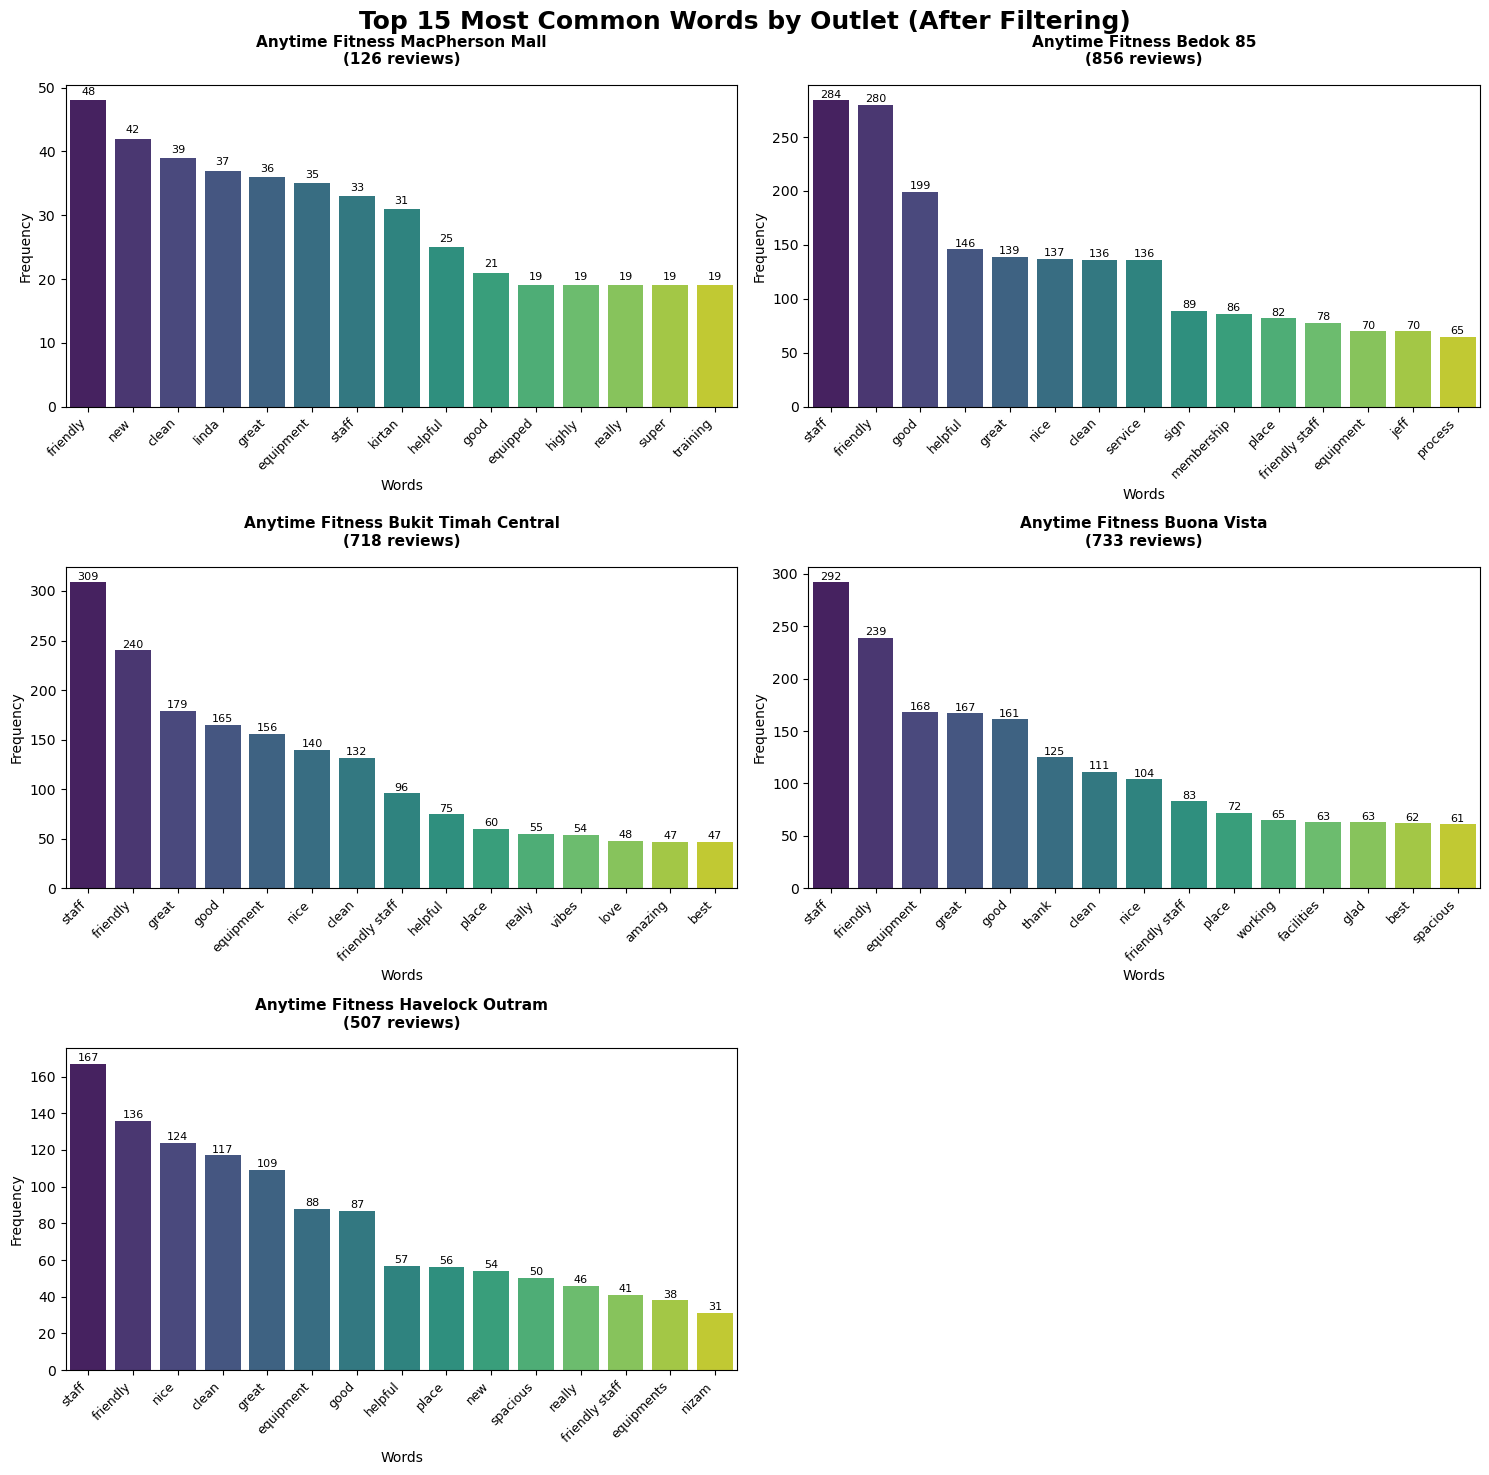

--------------------Bottom 5 Outlets--------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39204\2233607901.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts_top, palette='viridis', ax=axes[i])
C:\Users\Lenovo\AppData\Local\Temp\ipyke

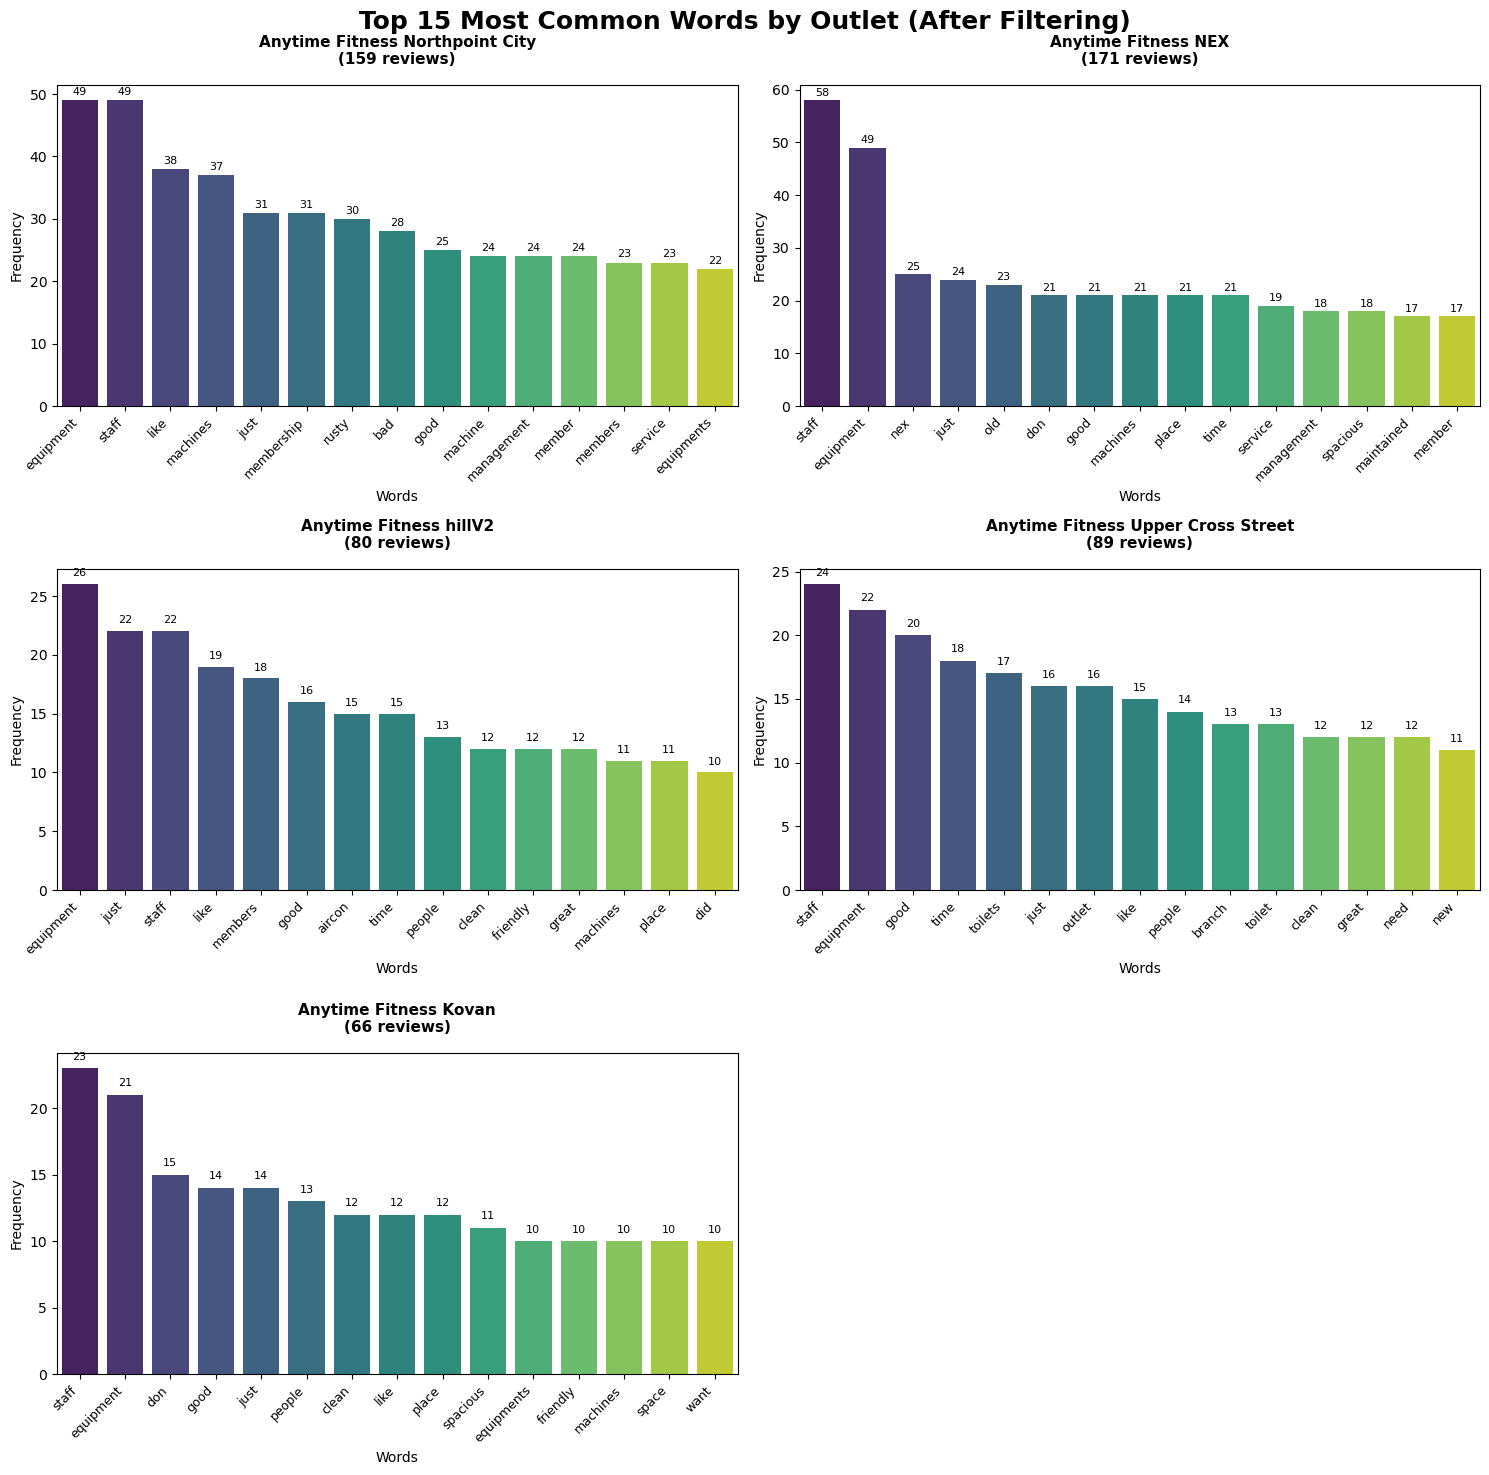

In [19]:
print("--------------------Top 5 Outlets--------------------")
analyze_outlet_word_frequencies(top_5_outlets, figsize=(15, 15))
print("--------------------Bottom 5 Outlets--------------------")
analyze_outlet_word_frequencies(bottom_5_outlets, figsize=(15, 15))

In [20]:
# Function to run topic modeling analysis for different outlets separately
def run_topic_modeling_per_outlet(outlet_names, num_topics=5, num_words=8, save_results=False):
    """
    Run topic modeling analysis for each outlet separately
    
    Parameters:
    outlet_names (list): List of outlet names to analyze
    num_topics (int): Number of topics to extract per outlet
    num_words (int): Number of words to show per topic
    save_results (bool): Whether to save results to files
    
    Returns:
    dict: Dictionary containing results for each outlet
    """
    import re
    import pandas as pd
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation as LDA
    import warnings
    warnings.simplefilter("ignore", DeprecationWarning)
    
    # Filter outlet names to only include those that exist in our data
    available_outlets = [name for name in outlet_names if name in outlet_dataframes]
    
    # Store results for each outlet
    outlet_results = {}
    
    # Define custom stop words
    custom_stop_words = [
        'gym', 'fitness', 'anytime', 'af', 'workout', 'exercise',
        'visit', 'go', 'come', 'use', 'work', 'train'
    ]
    
    all_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + custom_stop_words
    
    for outlet_name in available_outlets:
        # Get outlet data
        outlet_data = outlet_dataframes[outlet_name].copy()
        
        # Process text data
        outlet_data['text'] = outlet_data['text'].fillna('')
        outlet_data['review_text_processed'] = outlet_data['text'].map(
            lambda x: re.sub(r'[,.!?;:"()[\]{}]', '', str(x))
        )
        outlet_data['review_text_processed'] = outlet_data['review_text_processed'].map(
            lambda x: x.strip().lower()
        )
        
        # Remove empty reviews
        outlet_data = outlet_data[outlet_data['review_text_processed'] != '']
        
        
        if len(outlet_data) < 5:
            outlet_results[outlet_name] = {
                'status': 'insufficient_data',
                'review_count': len(outlet_data),
                'topics': None,
                'model': None,
                'vectorizer': None
            }
            continue
        
        try:
            # Create count vectorizer for this outlet
            count_vectorizer = CountVectorizer(
                stop_words=all_stop_words,
                min_df=2,
                max_df=0.8,
                ngram_range=(1, 2)
            )
            
            count_data = count_vectorizer.fit_transform(outlet_data['review_text_processed'])
            
            # Create and fit LDA model
            lda = LDA(n_components=num_topics, random_state=42)
            lda.fit(count_data)
            
            # Extract topics
            words = count_vectorizer.get_feature_names_out()
            topics = []
            
            print(f" Topics found for {outlet_name}:")
            for topic_idx, topic in enumerate(lda.components_):
                topic_words = [words[i] for i in topic.argsort()[:-num_words - 1:-1]]
                topics.append(topic_words)
                print(f"\nTopic #{topic_idx + 1}: {' '.join(topic_words)}")
            
            # Store results
            outlet_results[outlet_name] = {
                'status': 'success',
                'review_count': len(outlet_data),
                'topics': topics,
                'model': lda,
                'vectorizer': count_vectorizer,
                'count_data': count_data,
                'processed_data': outlet_data
            }
            
            # Calculate average rating if available
            if 'rating' in outlet_data.columns:
                avg_rating = outlet_data['rating'].mean()
                outlet_results[outlet_name]['avg_rating'] = avg_rating
                print(f"Average rating: {avg_rating:.2f}")
        
            print("--------------------------------------------------------------------------")
            
        except Exception as e:
            outlet_results[outlet_name] = {
                'status': 'error',
                'review_count': len(outlet_data),
                'error': str(e),
                'topics': None,
                'model': None,
                'vectorizer': None
            }
    return outlet_results


In [21]:

print("--------------------Top 5 Outlets--------------------")
run_topic_modeling_per_outlet(top_5_outlets, num_topics=10, num_words=10)


--------------------Top 5 Outlets--------------------
 Topics found for Anytime Fitness MacPherson Mall:

Topic #1: kirtan clean equipment experience machines good maintained new training sign

Topic #2: training equipment feel space ve kirtan trainers new environment just

Topic #3: especially great new good trainer equipments justin nico experience nice

Topic #4: session trainer kirtan highly great super recommend highly recommend friendly clean

Topic #5: staff clean highly crowded new environment equipment friendly love ve

Topic #6: friendly new helpful super friendly equipped amazing super great staff machine

Topic #7: friendly staff great friendly staff super linda kirtan equipped equipment new

Topic #8: welcoming friendly clean helpful kirtan equipment forward look mall macpherson

Topic #9: linda helpful new linda helpful spacious equipment nice end environment good

Topic #10: linda friendly service good clean service linda helpful new nice equipments
Average rating: 4.97


{'Anytime Fitness MacPherson Mall': {'status': 'success',
  'review_count': 126,
  'topics': [['kirtan',
    'clean',
    'equipment',
    'experience',
    'machines',
    'good',
    'maintained',
    'new',
    'training',
    'sign'],
   ['training',
    'equipment',
    'feel',
    'space',
    've',
    'kirtan',
    'trainers',
    'new',
    'environment',
    'just'],
   ['especially',
    'great',
    'new',
    'good',
    'trainer',
    'equipments',
    'justin',
    'nico',
    'experience',
    'nice'],
   ['session',
    'trainer',
    'kirtan',
    'highly',
    'great',
    'super',
    'recommend',
    'highly recommend',
    'friendly',
    'clean'],
   ['staff',
    'clean',
    'highly',
    'crowded',
    'new',
    'environment',
    'equipment',
    'friendly',
    'love',
    've'],
   ['friendly',
    'new',
    'helpful',
    'super friendly',
    'equipped',
    'amazing',
    'super',
    'great',
    'staff',
    'machine'],
   ['friendly',
    'staff',
 

In [23]:
print("--------------------Bottom 5 Outlets--------------------")
run_topic_modeling_per_outlet(bottom_5_outlets, num_topics=10, num_words=10)

--------------------Bottom 5 Outlets--------------------
 Topics found for Anytime Fitness Northpoint City:

Topic #1: staff good spacious friendly machine space machines pretty staff friendly just

Topic #2: staff member just trial machines area equipment time club members

Topic #3: equipment machines don staff place advertised good maintained better racks

Topic #4: membership bad equipment members rusty management time experience service air conditioning

Topic #5: equipment order just faulty bag lots didn space really staff

Topic #6: equipment membership signing cause outlet best good place share maintenance

Topic #7: like months outlet members fob key fob member key home sign

Topic #8: staff machines machine like month sales equipment friend joining dumbbell

Topic #9: like space service racks machines nice great staffs price machine

Topic #10: weights ok machines rusty need big experience old 10 water
Average rating: 2.51
-----------------------------------------------------

{'Anytime Fitness Northpoint City': {'status': 'success',
  'review_count': 159,
  'topics': [['staff',
    'good',
    'spacious',
    'friendly',
    'machine',
    'space',
    'machines',
    'pretty',
    'staff friendly',
    'just'],
   ['staff',
    'member',
    'just',
    'trial',
    'machines',
    'area',
    'equipment',
    'time',
    'club',
    'members'],
   ['equipment',
    'machines',
    'don',
    'staff',
    'place',
    'advertised',
    'good',
    'maintained',
    'better',
    'racks'],
   ['membership',
    'bad',
    'equipment',
    'members',
    'rusty',
    'management',
    'time',
    'experience',
    'service',
    'air conditioning'],
   ['equipment',
    'order',
    'just',
    'faulty',
    'bag',
    'lots',
    'didn',
    'space',
    'really',
    'staff'],
   ['equipment',
    'membership',
    'signing',
    'cause',
    'outlet',
    'best',
    'good',
    'place',
    'share',
    'maintenance'],
   ['like',
    'months',
    'outl

In [24]:
!pip install pyLDAvis==3.4.1

In [25]:
# Function to create LDA models and visualizations for selected outlets
def create_lda_models_for_outlets(outlet_names, num_topics=5, save_html=True, show_visualization=True):
    """
    Create LDA models and interactive pyLDAvis visualizations for selected outlets
    
    Parameters:
    outlet_names (list): List of outlet names to create LDA models for
    num_topics (int): Number of topics to extract per outlet
    save_html (bool): Whether to save visualizations as HTML files
    show_visualization (bool): Whether to display visualizations in notebook
    
    Returns:
    dict: Dictionary containing LDA models, visualizations, and metadata for each outlet
    """
    import re
    import os
    import pickle
    import warnings
    import pyLDAvis
    import pyLDAvis.lda_model
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation as LDA
    
    warnings.simplefilter("ignore", DeprecationWarning)
    
    # Filter outlet names to only include those that exist in our data
    available_outlets = [name for name in outlet_names if name in outlet_dataframes]
    
    # Store results for each outlet
    lda_models = {}
    
    # Define custom stop words
    custom_stop_words = [
        'gym', 'fitness', 'anytime', 'af', 'workout', 'exercise',
        'visit', 'go', 'come', 'use', 'work', 'train'
    ]
    
    all_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + custom_stop_words
    
    print("🔬 CREATING LDA MODELS AND VISUALIZATIONS")
    print("="*80)
    
    for outlet_name in available_outlets:
        # Get outlet data
        outlet_data = outlet_dataframes[outlet_name].copy()
        
        # Process text data
        outlet_data['text'] = outlet_data['text'].fillna('')
        outlet_data['review_text_processed'] = outlet_data['text'].map(
            lambda x: re.sub(r'[,.!?;:"()[\]{}]', '', str(x))
        )
        outlet_data['review_text_processed'] = outlet_data['review_text_processed'].map(
            lambda x: x.strip().lower()
        )
        
        # Remove empty reviews
        outlet_data = outlet_data[outlet_data['review_text_processed'] != '']
        
        try:
            count_vectorizer = CountVectorizer(
                stop_words=all_stop_words,
                min_df=2,
                max_df=0.8,
                ngram_range=(1, 2)
            )
            
            count_data = count_vectorizer.fit_transform(outlet_data['review_text_processed'])

            # Create and fit LDA model
            lda_model = LDA(n_components=num_topics, random_state=42, max_iter=100)
            lda_model.fit(count_data)
            
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=DeprecationWarning)
                ldavis_prepared = pyLDAvis.lda_model.prepare(lda_model, count_data, count_vectorizer)
            
            # Save visualization as HTML if requested
            if save_html:
                safe_outlet_name = outlet_name.replace(' ', '_').replace('/', '_')
                html_filename = f'lda_viz_{safe_outlet_name}.html'
                pyLDAvis.save_html(ldavis_prepared, html_filename)
                print(f"💾 Visualization saved as: {html_filename}")
            
            # Extract topics for display
            words = count_vectorizer.get_feature_names_out()
            topics = []
            
            # Store results
            lda_models[outlet_name] = {
                'status': 'success',
                'review_count': len(outlet_data),
                'model': lda_model,
                'vectorizer': count_vectorizer,
                'count_data': count_data,
                'visualization': ldavis_prepared,
                'topics': topics,
                'processed_data': outlet_data
            }
            
            # Display visualization in notebook if requested
            if show_visualization:
                print(f"\n📈 Interactive visualization for {outlet_name}:")
                pyLDAvis.enable_notebook()
                display(ldavis_prepared)
            
        except Exception as e:
            lda_models[outlet_name] = {
                'status': 'error',
                'review_count': len(outlet_data),
                'error': str(e),
                'model': None,
                'visualization': None
            }
    return lda_models

In [26]:
lda_models = create_lda_models_for_outlets(top_5_outlets, num_topics=10, save_html=True, show_visualization=True)

🔬 CREATING LDA MODELS AND VISUALIZATIONS
💾 Visualization saved as: lda_viz_Anytime_Fitness_MacPherson_Mall.html

📈 Interactive visualization for Anytime Fitness MacPherson Mall:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.070384  0.118333       1        1  16.979205
4     -0.095793 -0.015479       2        1  14.203122
1     -0.151276 -0.100066       3        1  12.615874
7      0.061590  0.042530       4        1  12.140948
6      0.046618  0.084691       5        1  10.592724
9      0.171282 -0.088774       6        1   8.649335
0     -0.074635 -0.045507       7        1   8.402465
2      0.022440 -0.039969       8        1   6.294288
5      0.025765  0.129497       9        1   5.768815
8      0.064392 -0.085257      10        1   4.353224, topic_info=         Term       Freq      Total Category  logprob  loglift
223     linda  29.000000  29.000000  Default  30.0000  30.0000
177   helpful  20.000000  20.000000  Default  29.0000  29.0000
135  friendly  40.000000  40.000000  Default  28.0000  28.0000
384     super  16.000000  16.000000  Default  27.0000  27.0000
369     staff  27.000000  27.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
253      mall   1.278399  13.157938  Topic10  -4.2384   0.8028
153      good   1.416000  17.451144  Topic10  -4.1362   0.6227
25       best   0.741720   8.169306  Topic10  -4.7828   0.7351
434   weights   0.741717   4.857368  Topic10  -4.7828   1.2550
132      free   0.741716   5.714341  Topic10  -4.7828   1.0925

[505 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.405050        24
0         7  0.405050        24
1         3  0.247969    access
1         7  0.495939    access
1         8  0.247969    access
...     ...       ...       ...
443       8  0.134933  workouts
443       9  0.134933  workouts
444       3  0.887457     works
445       3  0.887457     years
446       7  0.827514     young

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 8, 7, 10, 1, 3, 6, 9])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Bedok_85.html

📈 Interactive visualization for Anytime Fitness Bedok 85:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.088968  0.146606       1        1  16.574545
1      0.083449  0.037830       2        1  11.520705
6      0.113338 -0.204690       3        1  11.127389
0     -0.160123 -0.006577       4        1  10.761211
8     -0.222391  0.015592       5        1  10.183787
2     -0.011051 -0.117125       6        1  10.105511
9      0.070527  0.127785       7        1   9.917016
3      0.042451  0.022347       8        1   7.929042
7     -0.016735  0.056188       9        1   6.456389
5      0.011567 -0.077956      10        1   5.424406, topic_info=            Term        Freq       Total Category  logprob  loglift
462         good  172.000000  172.000000  Default  30.0000  30.0000
955      service  119.000000  119.000000  Default  29.0000  29.0000
767         nice  119.000000  119.000000  Default  28.0000  28.0000
0             10   33.000000   33.000000  Default  27.0000  27.0000
984         sign   78.000000   78.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
665      looking    3.301747   21.680457  Topic10  -4.9324   1.0323
119         best    3.141594   22.479691  Topic10  -4.9821   0.9464
345   explaining    2.976674   24.330092  Topic10  -5.0360   0.8134
1083       super    2.945457   31.284606  Topic10  -5.0466   0.5514
672         love    2.826370   23.528197  Topic10  -5.0878   0.7951

[642 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0        10  0.970738            10
1        10  0.963647         10 10
2         1  0.813530  10 recommend
2         5  0.162706  10 recommend
13        1  0.030661            85
...     ...       ...           ...
1230      6  0.142621  yuda helpful
1231      4  0.906014         yulun
1232      6  0.178517          yuni
1232      7  0.089258          yuni
1232      9  0.714068          yuni

[1105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 7, 1, 9, 3, 10, 4, 8, 6])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Bukit_Timah_Central.html

📈 Interactive visualization for Anytime Fitness Bukit Timah Central:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.218142 -0.012543       1        1  18.430234
0      0.023490 -0.037197       2        1  15.444499
8     -0.002322  0.034633       3        1  12.662166
1      0.038398  0.236001       4        1  10.468174
6     -0.136042  0.014375       5        1   8.995810
5      0.091757 -0.030325       6        1   7.908460
4     -0.007793 -0.076278       7        1   7.553375
3      0.162594 -0.006776       8        1   6.684381
7      0.043222 -0.130489       9        1   6.155190
9      0.004839  0.008600      10        1   5.697710, topic_info=                Term        Freq       Total Category  logprob  loglift
467            great  153.000000  153.000000  Default  30.0000  30.0000
437             good  140.000000  140.000000  Default  29.0000  29.0000
722             nice  119.000000  119.000000  Default  28.0000  28.0000
394         friendly  209.000000  209.000000  Default  27.0000  27.0000
408   friendly staff   85.000000   85.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1021           super    2.892685   38.913460  Topic10  -4.9518   0.2660
1130       welcoming    2.729656   30.097154  Topic10  -5.0098   0.4649
637             love    2.804053   42.179627  Topic10  -4.9829   0.1542
960            staff    2.631484  270.359573  Topic10  -5.0464  -1.7671
323       especially    2.542748   18.037244  Topic10  -5.0807   0.9059

[597 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         5  0.204434       10
0         6  0.204434       10
0         9  0.545159       10
1         5  0.210230    10 10
1         6  0.210230    10 10
...     ...       ...      ...
1148      5  0.089197  working
1148      6  0.267591  working
1148      9  0.267591  working
1152      3  0.194136    years
1152      8  0.582407    years

[1009 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 9, 2, 7, 6, 5, 4, 8, 10])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Buona_Vista.html

📈 Interactive visualization for Anytime Fitness Buona Vista:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.139412 -0.125905       1        1  14.531805
1      0.123901 -0.039832       2        1  14.156009
6      0.053140  0.128098       3        1  12.812171
2     -0.180181 -0.240437       4        1   9.806432
4      0.104395  0.022799       5        1   9.596378
5      0.014171  0.050041       6        1   9.465424
0     -0.255686  0.060001       7        1   8.265540
9      0.070886 -0.020287       8        1   7.645797
8     -0.175717  0.111741       9        1   7.400740
7      0.105681  0.053781      10        1   6.319704, topic_info=                Term        Freq       Total Category  logprob  loglift
1074           thank  107.000000  107.000000  Default  30.0000  30.0000
396         friendly  209.000000  209.000000  Default  29.0000  29.0000
463            great  147.000000  147.000000  Default  28.0000  28.0000
999            staff  256.000000  256.000000  Default  27.0000  27.0000
436             good  139.000000  139.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
409   friendly staff    6.292653   73.349169  Topic10  -4.4114   0.3056
40           amazing    4.696887   35.182174  Topic10  -4.7039   0.7479
463            great    5.673026  147.094324  Topic10  -4.5150  -0.4939
28              afbv    4.250396   24.265569  Topic10  -4.8037   1.0195
875            range    3.488195   19.359428  Topic10  -5.0014   1.0477

[583 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         5  0.906376            10
0         6  0.067139            10
1         5  0.914075         10 10
2         5  0.762310  10 recommend
5         2  0.223453            24
...     ...       ...           ...
1185      6  0.905198          wish
1188      3  0.035385       working
1188      4  0.477692       working
1188      7  0.406923       working
1188      8  0.053077       working

[951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 3, 5, 6, 1, 10, 9, 8])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Havelock_Outram.html

📈 Interactive visualization for Anytime Fitness Havelock Outram:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.089351 -0.028388       1        1  17.114911
5      0.077396  0.157153       2        1  11.626219
6     -0.022983 -0.059429       3        1  11.260435
8      0.050514  0.094970       4        1  10.462282
7      0.041826 -0.126594       5        1  10.404470
1      0.050144 -0.052193       6        1   9.958303
4     -0.004023  0.140098       7        1   9.921351
9      0.046536 -0.060233       8        1   8.521429
3     -0.021705 -0.086165       9        1   5.662707
0     -0.307055  0.020782      10        1   5.067893, topic_info=         Term        Freq       Total Category  logprob  loglift
496     place   48.000000   48.000000  Default  30.0000  30.0000
448      nice  106.000000  106.000000  Default  29.0000  29.0000
654     thank   19.000000   19.000000  Default  28.0000  28.0000
283     great   94.000000   94.000000  Default  27.0000  27.0000
632      star   17.000000   17.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
429     music    1.593535   11.913037  Topic10  -4.9348   0.9706
319   helpful    2.262428   50.410681  Topic10  -4.5843  -0.1215
248      fuss    1.003850    4.244281  Topic10  -5.3969   1.5405
264      good    1.274249   74.916337  Topic10  -5.1584  -1.0918
186  equipped    1.140294   21.440336  Topic10  -5.2694   0.0483

[559 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         2  0.627531             10
0         3  0.179295             10
0         6  0.179295             10
1         2  0.499832          10 10
1         3  0.166611          10 10
...     ...       ...            ...
719       6  0.769023  xinyi helpful
720       3  0.757976           year
721       4  0.193306             yi
721       5  0.579918             yi
722       5  0.776842    yi friendly

[933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 7, 9, 8, 2, 5, 10, 4, 1])

In [28]:
lda_models = create_lda_models_for_outlets(bottom_5_outlets, num_topics=10, save_html=True, show_visualization=True)

🔬 CREATING LDA MODELS AND VISUALIZATIONS
💾 Visualization saved as: lda_viz_Anytime_Fitness_Northpoint_City.html

📈 Interactive visualization for Anytime Fitness Northpoint City:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.124631  0.050469       1        1  16.562522
0      0.163182 -0.013643       2        1  14.542226
1     -0.089993 -0.006680       3        1  14.177116
8      0.074492  0.027962       4        1  12.979664
7      0.069387  0.048119       5        1   9.317173
6     -0.128318  0.005377       6        1   7.904630
2      0.023728  0.069525       7        1   7.616232
9      0.042158 -0.167436       8        1   6.714318
5     -0.065939 -0.089175       9        1   5.866487
4      0.035934  0.075481      10        1   4.319634, topic_info=              Term       Freq      Total Category  logprob  loglift
174      equipment  40.000000  40.000000  Default  30.0000  30.0000
342         member  20.000000  20.000000  Default  29.0000  29.0000
346     membership  26.000000  26.000000  Default  28.0000  28.0000
613        weights  11.000000  11.000000  Default  27.0000  27.0000
512          space  18.000000  18.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
410          place   1.429260  12.689224  Topic10  -4.4626   0.9584
517          staff   1.597634  41.736811  Topic10  -4.3512  -0.1209
302           like   1.429226  32.414623  Topic10  -4.4626   0.0205
149  disappointing   0.831013   6.310006  Topic10  -5.0048   1.1148
387            old   0.831024  16.997111  Topic10  -5.0048   0.1239

[545 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.178255      10
0         5  0.356510      10
0         8  0.356510      10
6         6  0.639149    able
6         9  0.319575    able
...     ...       ...     ...
629      10  0.111399   years
630       3  0.184771  yishun
630       4  0.184771  yishun
630       8  0.369543  yishun
630      10  0.184771  yishun

[1000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 9, 8, 7, 3, 10, 6, 5])

💾 Visualization saved as: lda_viz_Anytime_Fitness_NEX.html

📈 Interactive visualization for Anytime Fitness NEX:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.099397 -0.107109       1        1  19.198660
3     -0.103662  0.084975       2        1  13.167220
9     -0.049980 -0.012154       3        1  12.825562
8     -0.108408 -0.073750       4        1   9.973432
2      0.151832  0.003159       5        1   9.784289
4     -0.024843  0.128210       6        1   9.140289
7     -0.117625 -0.115083       7        1   8.209954
5      0.085061 -0.051668       8        1   6.234533
0      0.042534  0.043404       9        1   6.053174
1      0.025695  0.100017      10        1   5.412887, topic_info=         Term       Freq      Total Category  logprob  loglift
314       old  19.000000  19.000000  Default  30.0000  30.0000
453      time  17.000000  17.000000  Default  29.0000  29.0000
262  machines  18.000000  18.000000  Default  28.0000  28.0000
407   service  16.000000  16.000000  Default  27.0000  27.0000
426     staff  47.000000  47.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
207      home   0.785384   4.744253  Topic10  -5.0501   1.1179
413      sign   0.785384   6.599886  Topic10  -5.0501   0.7878
332    paying   0.785383   5.773859  Topic10  -5.0501   0.9215
502   website   0.785382   3.109878  Topic10  -5.0501   1.5402
420     smile   0.785381   3.192737  Topic10  -5.0501   1.5139

[528 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         3  0.208813         10
0         6  0.208813         10
0         7  0.417625         10
7         3  0.425701         30
7        10  0.425701         30
...     ...       ...        ...
520       2  0.800875  years ago
521       7  0.843939        yrs
522       1  0.248134       zero
522       7  0.496267       zero
523       7  0.843938    zero cs

[900 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 10, 9, 3, 5, 8, 6, 1, 2])

💾 Visualization saved as: lda_viz_Anytime_Fitness_hillV2.html

📈 Interactive visualization for Anytime Fitness hillV2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.096040 -0.020420       1        1  24.134926
5      0.138167  0.070094       2        1  16.916616
8     -0.130621  0.177742       3        1  10.742762
3      0.025663 -0.084684       4        1   9.974719
2     -0.022593 -0.028752       5        1   9.526212
9     -0.060047 -0.050847       6        1   7.081518
4     -0.065688 -0.068234       7        1   6.899707
1     -0.120520 -0.048069       8        1   5.159676
7      0.069433  0.057979       9        1   5.066680
0      0.070166 -0.004808      10        1   4.497183, topic_info=          Term       Freq      Total Category  logprob  loglift
17      aircon  12.000000  12.000000  Default  30.0000  30.0000
140      great   9.000000   9.000000  Default  29.0000  29.0000
98   equipment  21.000000  21.000000  Default  28.0000  28.0000
166       just  18.000000  18.000000  Default  27.0000  27.0000
137       good  13.000000  13.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
362    working   0.704392   3.839350  Topic10  -4.4886   1.4060
301      staff   0.704391  18.789281  Topic10  -4.4886  -0.1820
73    customer   0.704391   5.495122  Topic10  -4.4886   1.0474
249       poor   0.704391   4.953070  Topic10  -4.4886   1.1513
202       mask   0.704390   3.765867  Topic10  -4.4886   1.4253

[485 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.297575        10
0         2  0.595150        10
1         2  0.813482  10 admin
3         2  0.253247      2022
3         4  0.253247      2022
...     ...       ...       ...
367       5  0.516247      year
368       1  0.247709     years
368       2  0.247709     years
368       4  0.247709     years
368       7  0.247709     years

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 4, 3, 10, 5, 2, 8, 1])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Upper_Cross_Street.html

📈 Interactive visualization for Anytime Fitness Upper Cross Street:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.133442  0.033403       1        1  17.235432
9     -0.022297 -0.013953       2        1  15.385582
0     -0.031338  0.120865       3        1  14.004441
5     -0.116556  0.013655       4        1  13.339096
2     -0.118875  0.029856       5        1   9.862086
8     -0.041570 -0.182567       6        1   8.728944
1      0.147099  0.017860       7        1   7.255742
6     -0.023961  0.091202       8        1   5.099315
7      0.056217 -0.049590       9        1   5.029112
3      0.017841 -0.060733      10        1   4.060250, topic_info=         Term       Freq      Total Category  logprob  loglift
115      good  15.000000  15.000000  Default  30.0000  30.0000
277     staff  19.000000  19.000000  Default  29.0000  29.0000
110  friendly   8.000000   8.000000  Default  28.0000  28.0000
218     place   8.000000   8.000000  Default  27.0000  27.0000
299   toilets  14.000000  14.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
223      poor   0.691295   5.125888  Topic10  -4.3065   1.2004
108      free   0.691293   5.371769  Topic10  -4.3065   1.1536
304  training   0.691290   6.503345  Topic10  -4.3065   0.9624
327   weights   0.691290   6.351390  Topic10  -4.3065   0.9861
13       area   0.691288   5.593207  Topic10  -4.3065   1.1132

[455 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.303629        24
2         4  0.607258        24
3         2  0.609552       2nd
3         3  0.304776       2nd
4         1  0.631418        ac
...     ...       ...       ...
331       6  0.313251  workouts
332       6  0.465731     world
332      10  0.465731     world
333       1  0.891070     worst
334       3  0.821920   written

[684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 1, 6, 3, 9, 2, 7, 8, 4])

💾 Visualization saved as: lda_viz_Anytime_Fitness_Kovan.html

📈 Interactive visualization for Anytime Fitness Kovan:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.105558  0.051728       1        1  13.652253
2     -0.047800 -0.069294       2        1  12.611219
0     -0.157519 -0.043753       3        1  12.349723
6      0.169978  0.012281       4        1  12.127540
9      0.006773 -0.124392       5        1  11.520402
7     -0.024290  0.077519       6        1  10.528941
3     -0.100585  0.165031       7        1   9.790963
1     -0.005911 -0.117776       8        1   9.242440
5      0.038742  0.006088       9        1   4.475043
8      0.015056  0.042567      10        1   3.701476, topic_info=         Term       Freq      Total Category  logprob  loglift
76       good  10.000000  10.000000  Default  30.0000  30.0000
142     place   9.000000   9.000000  Default  29.0000  29.0000
36      clean   9.000000   9.000000  Default  28.0000  28.0000
215      want   8.000000   8.000000  Default  27.0000  27.0000
79      great   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
79      great   0.058476   4.761731  Topic10  -6.2046  -1.1033
188  spacious   0.058476   9.095843  Topic10  -6.2046  -1.7505
106    little   0.058476   2.338737  Topic10  -6.2046  -0.3923
101     kovan   0.058476   7.971486  Topic10  -6.2046  -1.6186
157      rude   0.058476   4.716799  Topic10  -6.2046  -1.0938

[452 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         2  0.940880            10
1         4  0.250974            24
1         5  0.752922            24
2         5  0.843638      24 hours
4         3  0.866480      adequate
...     ...       ...           ...
222       2  0.317947          yoga
222       6  0.635894          yoga
223       6  0.856748  yoga classes
224       2  0.424435         zumba
224       6  0.424435         zumba

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 7, 10, 8, 4, 2, 6, 9])